In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import models, optimizers, layers
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from IPython.display import display

In [2]:
#read data in
train_data = pd.read_csv('data.csv', header=None)
train_feats, train_labels = train_data.iloc[:, :294], train_data.iloc[:, 294:]

#Normally the data should be splitted into train, validation, and test. For simplicity, only into train and test dataset
train_feats, test_feats, train_labels, test_labels = train_test_split(train_feats, train_labels, test_size=0.2, random_state=88)

train_feats, test_feats = train_feats.reset_index(drop=True), test_feats.reset_index(drop=True)
train_labels, test_labels = train_labels.reset_index(drop=True), test_labels.reset_index(drop=True)

## Explore the data a little bit

In [3]:
print("size of the train and test datasets:")
print("train_feats: ", train_feats.shape, "train_labels: ", train_labels.shape)
print("test_feats: ", test_feats.shape, "test_labels: ", test_labels.shape)

size of the train and test datasets:
train_feats:  (1150, 294) train_labels:  (1150, 6)
test_feats:  (288, 294) test_labels:  (288, 6)


In [4]:
display(train_feats.head())
display(train_labels.head())

,0,1,2,3,4,5,6,7,8,9,...,284,285,286,287,288,289,290,291,292,293
0,0.967815,0.965305,0.967266,0.967333,0.968332,0.962403,0.954184,0.881903,0.907026,0.891654,...,0.090634,0.109361,0.064271,0.103973,0.068763,0.085394,0.038505,0.037156,0.044158,0.032838
1,0.842418,0.893117,0.932735,0.912363,0.877170,0.828890,0.765554,0.827268,0.871978,0.893163,...,0.128894,0.047990,0.019182,0.031557,0.071106,0.115174,0.166455,0.067135,0.075433,0.178611
2,0.660139,0.659172,0.849855,0.943170,0.923969,0.872920,0.801277,0.328766,0.502357,0.605386,...,0.141516,0.002776,0.221038,0.052332,0.084127,0.239873,0.000131,0.257406,0.075757,0.264696
3,0.726324,0.733052,0.737216,0.739765,0.742968,0.744964,0.745442,0.761413,0.766521,0.769302,...,0.212228,0.269081,0.136328,0.014263,0.031924,0.033488,0.039649,0.044403,0.048838,0.045074
4,0.230307,0.316863,0.136670,0.003641,0.194147,0.000000,0.012358,0.409292,0.508322,0.468011,...,0.197179,0.082869,0.005856,0.052804,0.059011,0.048150,0.098081,0.039436,0.140686,0.033844


,294,295,296,297,298,299
0,0,0,0,1,0,0
1,0,1,0,0,0,0
2,0,0,0,0,1,0
3,0,0,0,1,0,0
4,0,1,0,0,0,0


In [5]:
#Check how many targets in the train and test datasets have more than one label
sum(train_labels.sum(axis=1)>1)/len(train_labels), sum(test_labels.sum(axis=1)>1)/len(test_labels)

(0.06869565217391305, 0.0763888888888889)

As the purpose is to compare different approaches to deal with multi-label classification, and it seems the split of train and test dataset is reasonable, so no further data exploration is done.

In [6]:
#Global Params
FEATSIZE = 294
BATCHSIZE = 96
EPOCHS = 100

## Initial Test of the model

In [7]:
def accuracy(y_true, y_pred, dim=None):
    if dim is None:
        return sum(np.sum(y_true != y_pred, axis=1) == 0)/len(y_true)
    else:
        return sum(y_true.iloc[:,dim] == y_pred[:,dim])/len(y_true)

In [8]:
def tune_thresold(y_true, y_pred, each_label=False):
    thresh = np.linspace(0.05, 1, 19, False)
    best_acc = 0
    if each_label:
        thresh_dim = 6
        best_thresh = [0]*thresh_dim
        final_pred = y_pred.copy()
    else:
        thresh_dim = 1
        best_thresh = 0
        
    for td in range(thresh_dim):
        if each_label:
            best_acc = 0
            
        for t in thresh:
            if each_label:
                pred = y_pred.copy()
                pred[pred[:, td]>t, td] = 1
                pred[pred[:, td]<=t, td] = 0
                acc = accuracy(y_true, pred, dim=td)
            else:
                pred = y_pred.copy()
                pred[pred>t] = 1
                pred[pred<=t] = 0
                acc = accuracy(y_true, pred)
           
            if acc > best_acc:
                best_acc = acc
                if each_label:
                    final_pred[:,td] = pred[:,td]
                    best_thresh[td] = t
                else:
                    best_thresh = t
                    
    if each_label:
        best_acc = accuracy(y_true, final_pred)
        
    return best_thresh, best_acc

In [9]:
def create_model(loss="categorical_crossentropy", activation='sigmoid', output=6):
    model = models.Sequential()
    model.add(layers.Dense(32, input_shape=(FEATSIZE,),  activation='relu', name="first"))
    model.add(layers.Dense(32, activation='relu', name="second"))
    model.add(layers.Dropout(rate=0.3, name="dropout"))
    model.add(layers.Dense(output, activation=activation, name="output"))

    model.compile(optimizer="adam", loss=loss, metrics=['categorical_accuracy', 'accuracy'])

    return model

In [10]:
#First let's play a little to see which loss function, mean_squared_error vs categorical_crossentropy, is better
mdl = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=BATCHSIZE, validation_split=0.2, verbose=0)
param_grid = {"loss": ['categorical_crossentropy', 'mean_squared_error']}
grid = GridSearchCV(estimator=mdl, param_grid=param_grid)
grid_result = grid.fit(train_feats, train_labels)
# summarize results
print("Best: {:.4f} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{:.4f} ({:.4f}) with: {}".format(mean, stdev, param))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


c:\python\python37\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Instructions for updating:
Use tf.cast instead.
Best: 0.7365 using {'loss': 'mean_squared_error'}
0.7217 (0.0057) with: {'loss': 'categorical_crossentropy'}
0.7365 (0.0118) with: {'loss': 'mean_squared_error'}


(NOTE: this does not entirely suitable for multi-label classification as the accuracy here is based on assumption that each target has only one non-zero label. Nevertheless, the dataset does not have many targets that have more than one non-zero label)

In [11]:
grid.best_estimator_.predict(test_feats)[:5], grid.best_estimator_.predict_proba(test_feats)[:5]

(array([3, 2, 3, 4, 2]),
 array([[7.2062016e-03, 7.7785790e-02, 3.4451932e-02, 7.4068481e-01,
         3.5993624e-01, 1.5191138e-03],
        [3.0282557e-02, 1.3861805e-02, 9.4124752e-01, 6.5145463e-02,
         6.9417059e-03, 2.3387849e-02],
        [3.3472776e-03, 5.5384636e-04, 1.4746487e-03, 9.8467255e-01,
         1.5459496e-01, 5.3086877e-04],
        [4.2485267e-01, 3.0931830e-03, 3.3304095e-04, 2.7086467e-02,
         5.2228457e-01, 1.6542804e-01],
        [2.3603052e-02, 3.1743348e-03, 9.8218906e-01, 6.0245693e-03,
         4.1016936e-04, 1.4899671e-03]], dtype=float32))

In [12]:
preds = grid.best_estimator_.predict_proba(test_feats)
#assume the default threshold is 0.5; could be tuned later
preds[preds>0.5] = 1
preds[preds<=0.5] = 0
preds[:5]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [13]:
#Accuracy on the test dataset, and number of estimates that have more than one non-zero label
print('Test accuracy: {:.4f}, Percentage with more than one non-zero label: {:.2f}%' \
       .format(accuracy(test_labels, preds), sum(preds.sum(axis=1)>1)/len(test_labels)*100))

Test accuracy: 0.6111, Percentage with more than one non-zero label: 2.08%


## Method 1: Neural Network using Sigmoid activation

In [14]:
mdl1 = create_model()
mdl1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                9440      
_________________________________________________________________
second (Dense)               (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 6)                 198       
Total params: 10,694
Trainable params: 10,694
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = mdl1.fit(train_feats, train_labels, epochs=EPOCHS, batch_size=BATCHSIZE, validation_split=0.2)

Train on 920 samples, validate on 230 samples
Epoch 1/100
920/920 [==============================] - 0s 333us/sample - loss: 1.9244 - categorical_accuracy: 0.2011 - acc: 0.2011 - val_loss: 1.8712 - val_categorical_accuracy: 0.2696 - val_acc: 0.2696
Epoch 2/100
920/920 [==============================] - 0s 50us/sample - loss: 1.8653 - categorical_accuracy: 0.2772 - acc: 0.2772 - val_loss: 1.8235 - val_categorical_accuracy: 0.4000 - val_acc: 0.4000
Epoch 3/100
920/920 [==============================] - 0s 49us/sample - loss: 1.8075 - categorical_accuracy: 0.3641 - acc: 0.3641 - val_loss: 1.7668 - val_categorical_accuracy: 0.4739 - val_acc: 0.4739
Epoch 4/100
920/920 [==============================] - 0s 44us/sample - loss: 1.7480 - categorical_accuracy: 0.4283 - acc: 0.4283 - val_loss: 1.6907 - val_categorical_accuracy: 0.5435 - val_acc: 0.5435
Epoch 5/100
920/920 [==============================] - 0s 43us/sample - loss: 1.6726 - categorical_accuracy: 0.4413 - acc: 0.4413 - val_loss: 1.5

920/920 [==============================] - 0s 42us/sample - loss: 0.8224 - categorical_accuracy: 0.7239 - acc: 0.7239 - val_loss: 0.8392 - val_categorical_accuracy: 0.7304 - val_acc: 0.7304
Epoch 42/100
920/920 [==============================] - 0s 42us/sample - loss: 0.7618 - categorical_accuracy: 0.7598 - acc: 0.7598 - val_loss: 0.8072 - val_categorical_accuracy: 0.7304 - val_acc: 0.7304
Epoch 43/100
920/920 [==============================] - 0s 41us/sample - loss: 0.7818 - categorical_accuracy: 0.7652 - acc: 0.7652 - val_loss: 0.8089 - val_categorical_accuracy: 0.7391 - val_acc: 0.7391
Epoch 44/100
920/920 [==============================] - 0s 41us/sample - loss: 0.7790 - categorical_accuracy: 0.7380 - acc: 0.7380 - val_loss: 0.8155 - val_categorical_accuracy: 0.7435 - val_acc: 0.7435
Epoch 45/100
920/920 [==============================] - 0s 43us/sample - loss: 0.7718 - categorical_accuracy: 0.7674 - acc: 0.7674 - val_loss: 0.7998 - val_categorical_accuracy: 0.7348 - val_acc: 0.734

920/920 [==============================] - 0s 42us/sample - loss: 0.5928 - categorical_accuracy: 0.8283 - acc: 0.8283 - val_loss: 0.7522 - val_categorical_accuracy: 0.7522 - val_acc: 0.7522
Epoch 82/100
920/920 [==============================] - 0s 42us/sample - loss: 0.5965 - categorical_accuracy: 0.8228 - acc: 0.8228 - val_loss: 0.7658 - val_categorical_accuracy: 0.7652 - val_acc: 0.7652
Epoch 83/100
920/920 [==============================] - 0s 42us/sample - loss: 0.5960 - categorical_accuracy: 0.8185 - acc: 0.8185 - val_loss: 0.7789 - val_categorical_accuracy: 0.7435 - val_acc: 0.7435
Epoch 84/100
920/920 [==============================] - 0s 42us/sample - loss: 0.6356 - categorical_accuracy: 0.8054 - acc: 0.8054 - val_loss: 0.7706 - val_categorical_accuracy: 0.7609 - val_acc: 0.7609
Epoch 85/100
920/920 [==============================] - 0s 42us/sample - loss: 0.6108 - categorical_accuracy: 0.8043 - acc: 0.8043 - val_loss: 0.7432 - val_categorical_accuracy: 0.7696 - val_acc: 0.769

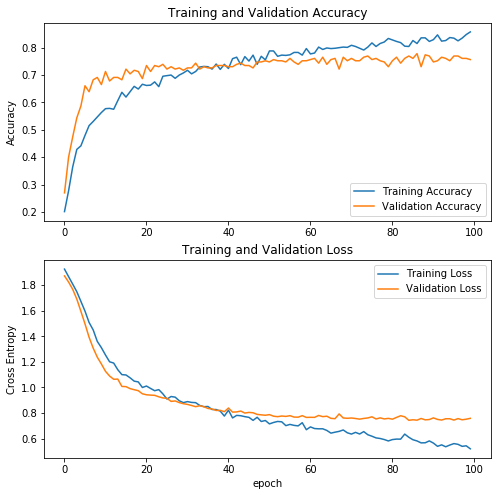

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
test_preds = mdl1.predict(test_feats)
#assume the default threshold is 0.5; could be tuned later
preds = test_preds.copy()
preds[preds>0.5] = 1
preds[preds<=0.5] = 0
preds[:5]

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [18]:
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.2569
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


### Tune the threshold and see if the performance is improved

In [19]:
train_preds = mdl1.predict(train_feats)
thresh, acc = tune_thresold(train_labels, train_preds)
print('best_acc: {:.4f} for best_threshold: {}'.format(acc, thresh))

best_acc: 0.6365 for best_threshold: 0.1


In [20]:
preds = test_preds.copy()
preds[preds>thresh] = 1
preds[preds<=thresh] = 0
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.4931
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


### Tune the threshold for each label and see if the performance is improved

In [21]:
thresh, acc = tune_thresold(train_labels, train_preds, each_label=True)
print('best_acc: {:.4f} for best_threshold: {}'.format(acc, thresh))

best_acc: 0.6817 for best_threshold: [0.1, 0.05, 0.05, 0.1, 0.15, 0.2]


In [22]:
preds = test_preds.copy()
for td in range(6):
    preds[preds[:,td]>thresh[td], td] = 1
    preds[preds[:,td]<=thresh[td], td] = 0
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.5590
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


## Method 2: Neural Network using Softmax activation

In [23]:
mdl2 = create_model(activation='softmax')
mdl2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                9440      
_________________________________________________________________
second (Dense)               (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 6)                 198       
Total params: 10,694
Trainable params: 10,694
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = mdl2.fit(train_feats, train_labels, epochs=EPOCHS, batch_size=BATCHSIZE, validation_split=0.2)

Train on 920 samples, validate on 230 samples
Epoch 1/100
920/920 [==============================] - 0s 355us/sample - loss: 1.9050 - categorical_accuracy: 0.2239 - acc: 0.2239 - val_loss: 1.8309 - val_categorical_accuracy: 0.3130 - val_acc: 0.3130
Epoch 2/100
920/920 [==============================] - 0s 46us/sample - loss: 1.8182 - categorical_accuracy: 0.2750 - acc: 0.2750 - val_loss: 1.7489 - val_categorical_accuracy: 0.3609 - val_acc: 0.3609
Epoch 3/100
920/920 [==============================] - 0s 49us/sample - loss: 1.7292 - categorical_accuracy: 0.3511 - acc: 0.3511 - val_loss: 1.6373 - val_categorical_accuracy: 0.5043 - val_acc: 0.5043
Epoch 4/100
920/920 [==============================] - 0s 46us/sample - loss: 1.6133 - categorical_accuracy: 0.3870 - acc: 0.3870 - val_loss: 1.5062 - val_categorical_accuracy: 0.5217 - val_acc: 0.5217
Epoch 5/100
920/920 [==============================] - 0s 47us/sample - loss: 1.5027 - categorical_accuracy: 0.4750 - acc: 0.4750 - val_loss: 1.3

Epoch 41/100
920/920 [==============================] - 0s 42us/sample - loss: 0.7460 - categorical_accuracy: 0.7446 - acc: 0.7446 - val_loss: 0.7946 - val_categorical_accuracy: 0.7130 - val_acc: 0.7130
Epoch 42/100
920/920 [==============================] - 0s 41us/sample - loss: 0.7473 - categorical_accuracy: 0.7620 - acc: 0.7620 - val_loss: 0.7828 - val_categorical_accuracy: 0.7435 - val_acc: 0.7435
Epoch 43/100
920/920 [==============================] - 0s 40us/sample - loss: 0.7329 - categorical_accuracy: 0.7685 - acc: 0.7685 - val_loss: 0.7758 - val_categorical_accuracy: 0.7130 - val_acc: 0.7130
Epoch 44/100
920/920 [==============================] - 0s 40us/sample - loss: 0.7335 - categorical_accuracy: 0.7793 - acc: 0.7793 - val_loss: 0.7928 - val_categorical_accuracy: 0.7261 - val_acc: 0.7261
Epoch 45/100
920/920 [==============================] - 0s 40us/sample - loss: 0.6938 - categorical_accuracy: 0.7859 - acc: 0.7859 - val_loss: 0.7810 - val_categorical_accuracy: 0.7261 - v

920/920 [==============================] - 0s 46us/sample - loss: 0.5743 - categorical_accuracy: 0.8435 - acc: 0.8435 - val_loss: 0.7381 - val_categorical_accuracy: 0.7391 - val_acc: 0.7391
Epoch 82/100
920/920 [==============================] - 0s 41us/sample - loss: 0.5593 - categorical_accuracy: 0.8250 - acc: 0.8250 - val_loss: 0.7437 - val_categorical_accuracy: 0.7609 - val_acc: 0.7609
Epoch 83/100
920/920 [==============================] - 0s 42us/sample - loss: 0.5737 - categorical_accuracy: 0.8272 - acc: 0.8272 - val_loss: 0.7392 - val_categorical_accuracy: 0.7478 - val_acc: 0.7478
Epoch 84/100
920/920 [==============================] - 0s 42us/sample - loss: 0.5595 - categorical_accuracy: 0.8424 - acc: 0.8424 - val_loss: 0.7457 - val_categorical_accuracy: 0.7478 - val_acc: 0.7478
Epoch 85/100
920/920 [==============================] - 0s 44us/sample - loss: 0.5576 - categorical_accuracy: 0.8391 - acc: 0.8391 - val_loss: 0.7475 - val_categorical_accuracy: 0.7391 - val_acc: 0.739

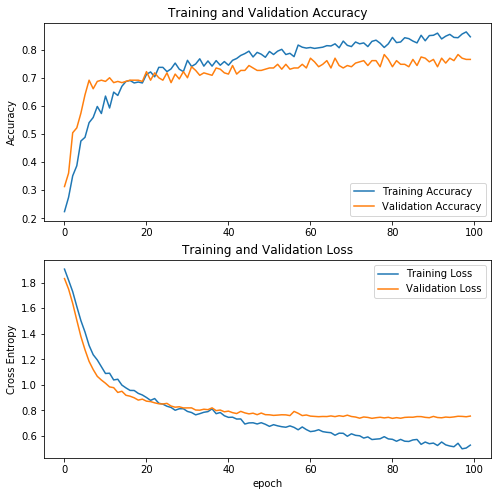

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
test_preds = mdl2.predict(test_feats)
#assume the default threshold is 0.5; could be tuned later
preds = test_preds.copy()
preds[preds>0.5] = 1
preds[preds<=0.5] = 0
preds[:5]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [27]:
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6736
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


### Tune the threshold and see if the performance is improved

In [28]:
train_preds = mdl2.predict(train_feats)
thresh, acc = tune_thresold(train_labels, train_preds)
print('best_acc: {:.4f} for best_threshold: {}'.format(acc, thresh))

best_acc: 0.8026 for best_threshold: 0.35


In [29]:
preds = test_preds.copy()
preds[preds>thresh] = 1
preds[preds<=thresh] = 0
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6736
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0455


### Tune the threshold for each label and see if the performance is improved

In [30]:
thresh, acc = tune_thresold(train_labels, train_preds, each_label=True)
print('best_acc: {:.4f} for best_threshold: {}'.format(acc, thresh))

best_acc: 0.8148 for best_threshold: [0.49999999999999994, 0.35, 0.44999999999999996, 0.35, 0.35, 0.49999999999999994]


In [31]:
preds = test_preds.copy()
for td in range(6):
    preds[preds[:,td]>thresh[td], td] = 1
    preds[preds[:,td]<=thresh[td], td] = 0
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6910
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0455


## Method 3: Expand the samples with multiple non-zero label into multiple samples with single non-zero label and using Neural Network using Softmax activation

In [32]:
def expand_samples(feats, labels):
    #index to sample with more than 1 non-zero sample and otherwise
    idx1 = labels.sum(axis=1)<=1
    idx2 = labels[labels.sum(axis=1)>1].index
    
    new_feats = feats[idx1].copy()
    new_labels = labels[idx1].copy()
    
    for idx in idx2:
        label = labels.iloc[idx,:]
        feat = feats.iloc[idx,:]
        for label_pos in np.where(label)[0]:
            new_label = [0]*6
            new_label[label_pos] = 1
            new_feats = new_feats.append(feat, ignore_index=True)
            new_labels = new_labels.append(pd.DataFrame([new_label], columns=labels.columns), ignore_index=True)
            
    return new_feats, new_labels

In [33]:
new_feats, new_labels = expand_samples(train_feats, train_labels)

In [34]:
mdl3 = create_model(activation='softmax')
mdl3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                9440      
_________________________________________________________________
second (Dense)               (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 6)                 198       
Total params: 10,694
Trainable params: 10,694
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = mdl3.fit(new_feats, new_labels, epochs=EPOCHS, batch_size=BATCHSIZE, validation_split=0.2)

Train on 983 samples, validate on 246 samples
Epoch 1/100
983/983 [==============================] - 0s 370us/sample - loss: 1.8074 - categorical_accuracy: 0.1770 - acc: 0.1770 - val_loss: 1.7550 - val_categorical_accuracy: 0.2683 - val_acc: 0.2683
Epoch 2/100
983/983 [==============================] - 0s 48us/sample - loss: 1.7166 - categorical_accuracy: 0.2828 - acc: 0.2828 - val_loss: 1.7501 - val_categorical_accuracy: 0.3049 - val_acc: 0.3049
Epoch 3/100
983/983 [==============================] - 0s 49us/sample - loss: 1.6577 - categorical_accuracy: 0.3530 - acc: 0.3530 - val_loss: 1.6984 - val_categorical_accuracy: 0.3496 - val_acc: 0.3496
Epoch 4/100
983/983 [==============================] - 0s 44us/sample - loss: 1.5766 - categorical_accuracy: 0.3927 - acc: 0.3927 - val_loss: 1.6450 - val_categorical_accuracy: 0.3780 - val_acc: 0.3780
Epoch 5/100
983/983 [==============================] - 0s 44us/sample - loss: 1.5032 - categorical_accuracy: 0.4323 - acc: 0.4323 - val_loss: 1.6

983/983 [==============================] - 0s 46us/sample - loss: 0.6052 - categorical_accuracy: 0.7579 - acc: 0.7579 - val_loss: 1.2615 - val_categorical_accuracy: 0.5528 - val_acc: 0.5528
Epoch 42/100
983/983 [==============================] - 0s 44us/sample - loss: 0.5947 - categorical_accuracy: 0.7711 - acc: 0.7711 - val_loss: 1.2222 - val_categorical_accuracy: 0.5650 - val_acc: 0.5650
Epoch 43/100
983/983 [==============================] - 0s 49us/sample - loss: 0.5781 - categorical_accuracy: 0.7803 - acc: 0.7803 - val_loss: 1.2696 - val_categorical_accuracy: 0.5569 - val_acc: 0.5569
Epoch 44/100
983/983 [==============================] - 0s 49us/sample - loss: 0.5643 - categorical_accuracy: 0.7945 - acc: 0.7945 - val_loss: 1.2864 - val_categorical_accuracy: 0.5610 - val_acc: 0.5610
Epoch 45/100
983/983 [==============================] - 0s 53us/sample - loss: 0.5826 - categorical_accuracy: 0.7823 - acc: 0.7823 - val_loss: 1.2479 - val_categorical_accuracy: 0.5610 - val_acc: 0.561

983/983 [==============================] - 0s 44us/sample - loss: 0.3839 - categorical_accuracy: 0.8678 - acc: 0.8678 - val_loss: 1.4510 - val_categorical_accuracy: 0.5447 - val_acc: 0.5447
Epoch 82/100
983/983 [==============================] - 0s 45us/sample - loss: 0.3844 - categorical_accuracy: 0.8576 - acc: 0.8576 - val_loss: 1.4250 - val_categorical_accuracy: 0.5569 - val_acc: 0.5569
Epoch 83/100
983/983 [==============================] - 0s 44us/sample - loss: 0.3827 - categorical_accuracy: 0.8566 - acc: 0.8566 - val_loss: 1.4238 - val_categorical_accuracy: 0.5610 - val_acc: 0.5610
Epoch 84/100
983/983 [==============================] - 0s 45us/sample - loss: 0.3597 - categorical_accuracy: 0.8800 - acc: 0.8800 - val_loss: 1.4545 - val_categorical_accuracy: 0.5569 - val_acc: 0.5569
Epoch 85/100
983/983 [==============================] - 0s 44us/sample - loss: 0.3687 - categorical_accuracy: 0.8596 - acc: 0.8596 - val_loss: 1.4746 - val_categorical_accuracy: 0.5610 - val_acc: 0.561

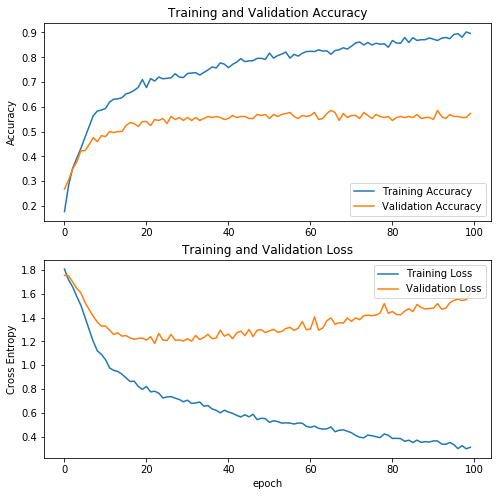

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
test_preds = mdl3.predict(test_feats)
#assume the default threshold is 0.5; could be tuned later
preds = test_preds.copy()
preds[preds>0.5] = 1
preds[preds<=0.5] = 0
preds[:5]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [38]:
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6875
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


### Tune the threshold and see if the performance is improved

In [39]:
train_preds = mdl3.predict(train_feats)
thresh, acc = tune_thresold(train_labels, train_preds)
print('best_acc: {:.4f} for best_threshold: {}'.format(acc, thresh))

best_acc: 0.8391 for best_threshold: 0.39999999999999997


In [40]:
preds = test_preds.copy()
preds[preds>thresh] = 1
preds[preds<=thresh] = 0
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6840
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


### Tune the threshold for each label and see if the performance is improved

In [41]:
thresh, acc = tune_thresold(train_labels, train_preds, each_label=True)
print('best_acc: {:.4f} for best_threshold: {}'.format(acc, thresh))

best_acc: 0.8461 for best_threshold: [0.44999999999999996, 0.6, 0.49999999999999994, 0.49999999999999994, 0.39999999999999997, 0.35]


In [42]:
preds = test_preds.copy()
for td in range(6):
    preds[preds[:,td]>thresh[td], td] = 1
    preds[preds[:,td]<=thresh[td], td] = 0
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6875
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


## Method 4: Neural Network using Fake Tags and Softmax activation

In [43]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical

In [44]:
label_encoder = LabelEncoder()

In [45]:
def encode_multi_tag(labels):
    new_labels = []
    for l in labels.values:
        new_labels.append(','.join(map(str, l)))
    new_labels = label_encoder.fit_transform(new_labels)
    new_labels = to_categorical(new_labels)
    return new_labels

(NOTE: it is verified that train dataset has all the occurrence of different tag combinations seen in the test dataset)

In [46]:
new_labels = encode_multi_tag(train_labels)

In [47]:
mdl4 = create_model(activation='softmax', output=12)
mdl4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                9440      
_________________________________________________________________
second (Dense)               (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 12)                396       
Total params: 10,892
Trainable params: 10,892
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = mdl4.fit(train_feats, new_labels, epochs=EPOCHS, batch_size=BATCHSIZE, validation_split=0.2)

Train on 920 samples, validate on 230 samples
Epoch 1/100
920/920 [==============================] - 0s 378us/sample - loss: 2.4307 - categorical_accuracy: 0.1174 - acc: 0.1174 - val_loss: 2.3076 - val_categorical_accuracy: 0.1478 - val_acc: 0.1478
Epoch 2/100
920/920 [==============================] - 0s 48us/sample - loss: 2.2807 - categorical_accuracy: 0.1793 - acc: 0.1793 - val_loss: 2.1647 - val_categorical_accuracy: 0.2348 - val_acc: 0.2348
Epoch 3/100
920/920 [==============================] - 0s 51us/sample - loss: 2.1602 - categorical_accuracy: 0.2217 - acc: 0.2217 - val_loss: 2.0421 - val_categorical_accuracy: 0.3261 - val_acc: 0.3261
Epoch 4/100
920/920 [==============================] - 0s 49us/sample - loss: 2.0446 - categorical_accuracy: 0.2500 - acc: 0.2500 - val_loss: 1.9112 - val_categorical_accuracy: 0.4000 - val_acc: 0.4000
Epoch 5/100
920/920 [==============================] - 0s 50us/sample - loss: 1.9675 - categorical_accuracy: 0.2750 - acc: 0.2750 - val_loss: 1.8

920/920 [==============================] - 0s 48us/sample - loss: 0.8456 - categorical_accuracy: 0.7152 - acc: 0.7152 - val_loss: 0.8729 - val_categorical_accuracy: 0.6609 - val_acc: 0.6609
Epoch 42/100
920/920 [==============================] - 0s 49us/sample - loss: 0.8194 - categorical_accuracy: 0.7228 - acc: 0.7228 - val_loss: 0.8704 - val_categorical_accuracy: 0.6609 - val_acc: 0.6609
Epoch 43/100
920/920 [==============================] - 0s 49us/sample - loss: 0.8184 - categorical_accuracy: 0.7250 - acc: 0.7250 - val_loss: 0.8750 - val_categorical_accuracy: 0.6957 - val_acc: 0.6957
Epoch 44/100
920/920 [==============================] - 0s 43us/sample - loss: 0.8140 - categorical_accuracy: 0.7304 - acc: 0.7304 - val_loss: 0.8682 - val_categorical_accuracy: 0.6565 - val_acc: 0.6565
Epoch 45/100
920/920 [==============================] - 0s 42us/sample - loss: 0.8074 - categorical_accuracy: 0.7185 - acc: 0.7185 - val_loss: 0.8703 - val_categorical_accuracy: 0.6609 - val_acc: 0.660

920/920 [==============================] - 0s 43us/sample - loss: 0.6042 - categorical_accuracy: 0.8043 - acc: 0.8043 - val_loss: 0.8184 - val_categorical_accuracy: 0.7000 - val_acc: 0.7000
Epoch 82/100
920/920 [==============================] - 0s 43us/sample - loss: 0.5900 - categorical_accuracy: 0.7935 - acc: 0.7935 - val_loss: 0.8107 - val_categorical_accuracy: 0.6870 - val_acc: 0.6870
Epoch 83/100
920/920 [==============================] - 0s 42us/sample - loss: 0.5935 - categorical_accuracy: 0.7946 - acc: 0.7946 - val_loss: 0.8200 - val_categorical_accuracy: 0.6783 - val_acc: 0.6783
Epoch 84/100
920/920 [==============================] - 0s 42us/sample - loss: 0.6054 - categorical_accuracy: 0.7935 - acc: 0.7935 - val_loss: 0.8210 - val_categorical_accuracy: 0.7000 - val_acc: 0.7000
Epoch 85/100
920/920 [==============================] - 0s 44us/sample - loss: 0.5821 - categorical_accuracy: 0.8011 - acc: 0.8011 - val_loss: 0.8076 - val_categorical_accuracy: 0.6957 - val_acc: 0.695

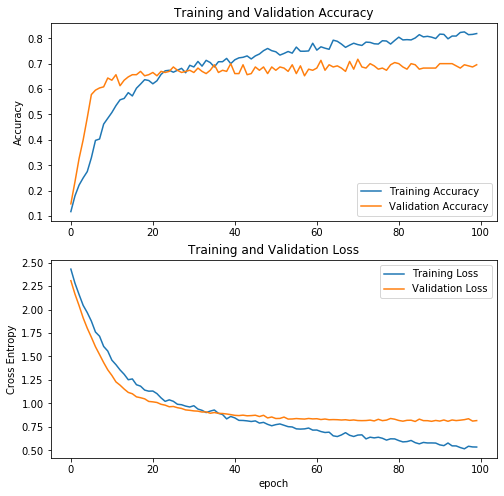

In [49]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [50]:
def assign_prob_to_tags(preds):
    pred_class = np.argmax(preds, axis=1)
    orig_labels = label_encoder.inverse_transform(pred_class)
    probs = []
    for i in range(len(orig_labels)):
        ol = np.array(list(map(int, orig_labels[i].split(','))), dtype=np.float16)
        ol[ol==1] = preds[i, pred_class[i]]
        probs.append(ol)
   
    return np.array(probs)

In [51]:
test_preds = mdl4.predict(test_feats)
test_preds = assign_prob_to_tags(test_preds)
#assume the default threshold is 0.5; could be tuned later
preds = test_preds.copy()
preds[preds>0.5] = 1
preds[preds<=0.5] = 0
preds[:5]

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float16)

In [52]:
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6493
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


### Tune the threshold and see if the performance is improved

In [53]:
train_preds = mdl4.predict(train_feats)
train_preds = assign_prob_to_tags(train_preds)
thresh, acc = tune_thresold(train_labels, train_preds)
print('best_acc: {:.4f} for best_threshold: {}'.format(acc, thresh))

best_acc: 0.8304 for best_threshold: 0.05


In [54]:
preds = test_preds.copy()
preds[preds>thresh] = 1
preds[preds<=thresh] = 0
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6910
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


### Tune the threshold for each label and see if the performance is improved

In [55]:
thresh, acc = tune_thresold(train_labels, train_preds, each_label=True)
print('best_acc: {:.4f} for best_threshold: {}'.format(acc, thresh))

best_acc: 0.8296 for best_threshold: [0.3, 0.05, 0.05, 0.25, 0.35, 0.05]


In [56]:
preds = test_preds.copy()
for td in range(6):
    preds[preds[:,td]>thresh[td], td] = 1
    preds[preds[:,td]<=thresh[td], td] = 0
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6910
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


#### The data used in this test is very small, therefore, no conclusive statements could be made. Instead the practice is to explore and preliminarily compare the different methods to deal with multi-label classification problem. Based on this very preliminary test, it seems some methods (e.g. method 1) may not be able to predict correctly for the sample with more than one non-zero label, while other methods cannot. Nevertheless, tuning the threshold based on the training data indeed increase the predict accuracy on the test dataset.